In [1]:
#Yb-171#


from qutip import*
from numpy import*
from sympy.physics.wigner import wigner_3j
import scipy.constants as C
import matplotlib.pyplot as plt


In [2]:
#定义常数#


i = 0+1j # 虚数单位
hbar = C.h/(2*pi) # 约化普朗克常数
epsilon_0 = 8.854e-12 # 真空介电常数

alpha_K = [-7.3141335e-35,4.8761815e-35,0] # reduced polarizability
alpha_s_F = -2.9859825e-35
alpha_v_F = -2.8152647e-35
F = 1/2
M = [1/2,-1/2]

u = array([0,-1/sqrt(2),i/sqrt(2)]) # polarization vector
K = [0,1,2]

P = 4 # 光功率(mW)
omega_0 = 550 # (um)
I_0 = P*1e-3*2/(C.c*pi*(omega_0*1e-6)**2) # 中心光功率密度
epsilon_square = I_0*2/epsilon_0 # 电矢量模平方


In [3]:
#spherical tensor components of the polarization vector u#


def Spherical_Ten(u,miu):
    
    if miu == -1:
        u_miu = (u[0]-u[1]*i)/sqrt(2)
    elif miu == 0:
        u_miu = u[2]
    elif miu == 1:
        u_miu = -(u[0]+u[1]*i)/sqrt(2)
    else:
        print('input error!\n')
        return
    return u_miu


In [4]:
#compound tensor components#
#u should be nomalizied#


def Compound_Ten_K_q(u,K,q):
    
    compound_ten = 0
    for miu1 in range(-1,2):
        for miu2 in range(-1,2):
            u_miu1 = Spherical_Ten(u,miu1)
            u_negamiu2 = Spherical_Ten(u,-miu2)
            u_negamiu2_star = u_negamiu2.conjugate()
            cplex = (-1)**(q+miu2)*u_miu1*u_negamiu2_star*sqrt(2*K+1)*wigner_3j(1,K,1,miu1,-q,miu2)
            compound_ten = compound_ten+cplex
    return compound_ten


In [5]:
#构造哈密顿量和初态#


#Hamiltonian#
def Hamiltonian(u,K):
    
    H = array([[0,0],[0,0]],dtype=float64) # 初始化
    
    # 哈密顿量矩阵元
    for M1_num in range(len(M)):
        for M2_num in range(len(M)):
            H_M1_num_M2_num = 0
            for K_num in range(len(K)):
                q = zeros(2*len(K)+1)
                for q_num in range(len(q)):
                    q[q_num] = -K[K_num]+q_num
                    com_ten_K_q = Compound_Ten_K_q(u,K[K_num],q[q_num]) # compound tensor component
                    H_M1_num_M2_num = H_M1_num_M2_num+(-1)**(K[K_num]+q[q_num])*com_ten_K_q\
                    *(-1)**(F-M[M1_num])*wigner_3j(F,K[K_num],F,-M[M1_num],-q[q_num],M[M2_num])\
                    *alpha_K[K_num]
                    
            H[M1_num,M2_num] = H_M1_num_M2_num*(epsilon_square/4)/C.h
            
    return H

#initial state,|+1/2>#
in_state = basis(2,0)


In [6]:
#定义基矢#


def Basis_Ham():
    
    # [[1,0],[0,0]]
    H1 = (1/2)*(sigmaz()+sigmaz()*sigmaz())
    # [[0,1],[0,0]]
    H2 = (1/2)*(sigmax()+i*sigmay())
    # [[0,0],[1,0]]
    H3 = (1/2)*(sigmax()-i*sigmay())
    # [[0,0],[0,1]]
    H4 = (1/2)*(-sigmaz()+sigmaz()*sigmaz())
    return H1,H2,H3,H4
    

In [7]:
#定义函数计算态演化#


def Solve_Ham(H,in_sta,tlist):
    
    #基矢定义#
    H1,H2,H3,H4 = Basis_Ham()
    
    Ham = H[0][0]*H1+H[0][1]*H2+H[1][0]*H3+H[1][1]*H4
    t_sta1 = sesolve(Ham,in_sta,tlist)
    t_sta2 = sesolve(Ham,in_sta,tlist,[sigmaz()])
    return t_sta1,t_sta2.expect


In [11]:
#计算态演化#


tau = 3.710685*4 # 进动时长(us)
step = 200 # 计算步数
tlist = linspace(0,tau*1e-6,step) # list of times for which the solver should store the state vector

Ham = Hamiltonian(u,K) # Hamiltonian
print('Hamiltonian:')
print(Ham)
eigenvalue,featurevector = linalg.eig(Ham) # eigenvalue of the Hamiltonian
print('\neigenvalue:')
print(eigenvalue)
print('\ndiff:')
print(eigenvalue[0]-eigenvalue[1])

t_state,t_state_expect = Solve_Ham(2*pi*Ham,in_state,tlist) # the state at t, qutip哈密顿量需乘以2*pi
#tran_t_state = transpose(t_state.states)
print('\nstate:')
print(t_state.states[-1])


Hamiltonian:
[[ 71458.80469684 -33686.64261199]
 [-33686.64261199  71458.80469684]]

eigenvalue:
[105145.44730883  37772.16208485]

diff:
67373.28522397997

state:
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-9.28284375e-01+3.71871103e-01j]
 [-3.70486817e-05+1.69894194e-05j]]


<function matplotlib.pyplot.show(close=None, block=None)>

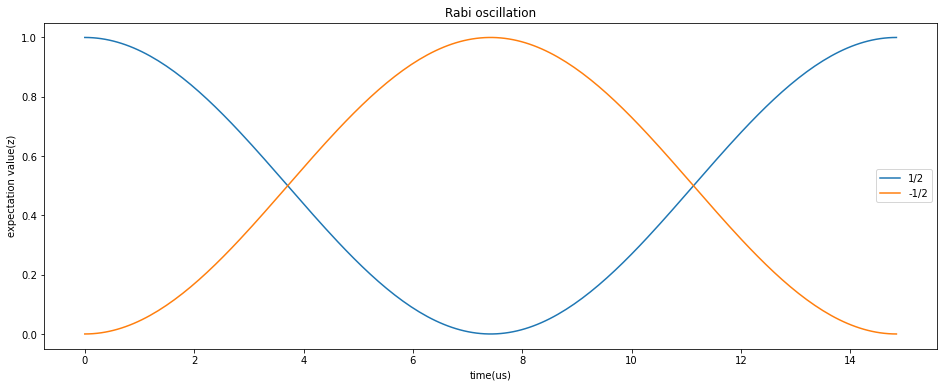

In [12]:
#布居数随时间演化#


t_ele = zeros((int(2*F+1),len(tlist)))

plt.figure(figsize=(16,6))
for ele_num in range(int(2*F+1)):
    
    for t_num in range(len(tlist)):
        t_ele[ele_num,t_num] = abs(t_state.states[t_num][ele_num])**2
        
    str1 = str(1-ele_num*2)
    str2 = '/2'
    plt.plot(tlist*1e6,t_ele[ele_num,:],label = str1+str2)
    plt.legend()

#plt.plot(tlist*1e6,t_state.states[:,1])
plt.xlabel('time(us)')
plt.ylabel('expectation value(z)')
plt.title('Rabi oscillation')
plt.show


In [10]:
#考虑decohenrence#


#Gaussian Sampling#

loc = 1 # 均值
scale = 0.1 # 标准差
size = 100 # 抽样数
sample = random.normal(loc,scale,size)
in_state_deco = basis(2,0)

tau_deco = 500 # 进动时长(us)
step_deco = 1000 # 计算步数
tlist_deco = linspace(0,tau_deco*1e-6,step) # list of times for which the solver should store the state vector

t_state_deco = zeros(len(tlist_deco))
for sample_num in range(len(sample)):
    H = sample[sample_num]*Hamiltonian(u,K)
    t_state_deco_num = Solve_Ham(H,in_state_deco,tlist_deco)
    t_state_deco = t_state_deco+t_state_deco_num

t_state_deco = t_state_deco/size
tran_t_state_deco = transpose(t_state_deco)


C:\Users\ZHANGJ~1\AppData\Local\Temp/ipykernel_4056/2773888588.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t_state_deco = t_state_deco+t_state_deco_num


ValueError: operands could not be broadcast together with shapes (200,) (2,) 

In [ ]:

plt.figure(figsize=(16,6))
plt.plot(tlist_deco*1e6,tran_t_state_deco)
plt.xlabel('time(us)')
plt.ylabel('expectation value(z)')
plt.title('decohenrence Rabi oscillation')
plt.show


In [ ]:
#相位随时间累加#

def Solve_Phase_Evolution(H,in_state,tlist):
    
    
    for t_num in range(len(tlist)):
        H = [H,sam]
        